In [50]:
import numpy as np
import argparse
from datetime import datetime
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K
from func import mse_loss
from sklearn.metrics import roc_curve, auc


def autoencoder(to_save_m,m_save_path,save_plots,s_plots_path):
    
    if save_plots == "y":
        date= datetime.now().strftime("_%d_%m")
        plot_name = input("Enter plots name(date is added automatically): ")
        plot_name = plot_name+date


    signal_in='./OH_signals/'
    bkg_filename = './OH_signals/BKG_OH2_OH_dataset.h5'
    X_train,X_test,X_val,signal_data,signal_labels=read_bkg_and_signals(bkg_filename,signal_in)
    
    # add correct signal labels
    data_labels  = ['Ato4l_lepFilter_13TeV_output',
                     'hChToTauNu_13TeV_PU20_output',
                     'hToTauTau_13TeV_PU20_output',
                     'leptoquark_LOWMASS_lepFilter_13TeV_output',
                     'background_for_training_output']
    
    EPOCHS = 1
    BATCH_SIZE = 1024
    autoencoder=AE_setup_training(EPOCHS,BATCH_SIZE,X_train,X_test,X_val,signal_data,signal_labels)
    
    if to_save_m=='y':
        #model_name = 'DENSE_AE_OH4_model_flops_test'
        #model_directory = './models/'
        print("Saving model..")
        autoencoder.save(m_save_path)
        #save_model(model_directory+model_name, autoencoder)
        print("Model save complete")
    
    #print('TF Profile: Total number of FLOPs =  {}'.format(get_flops(model_directory+model_name))
    
    AE_OH_results=predict_signal_bkg(X_test,signal_data,autoencoder)
    #reshape the results and reverse OH vectors with argmax to single type of object
    resh_type_results=OH_reverse_convert(AE_OH_results)
    #Plot results: mse loss, Roc curve, MET_pt attribute for signal and background
    plotting(X_test,AE_OH_results,signal_data,signal_labels,s_plots_path,plot_name)


In [ ]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--save_model", type=str, default="n", help="Save model or not", choices=["y","n"])
    parser.add_argument("--m_save_path", type=str, default=None, help="Save model to path(with intended model name)")
    parser.add_argument("--save_plots", type=str, default="n", help="Save plots or not", choices=["y", "n"] )
    parser.add_argument("--s_plots_path", type=str, default=None, help="Save plots to path..")
    args = parser.parse_args()
    return args

if __name__ == "__main__":
    args = vars(parse_args())
    autoencoder(args['save_model'],args['m_save_path'],args['--save_plots'],args['--s_plots_path'])
    

Enter plots name(date is added automatically): plots_test1
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 152)]             0         
                                                                 
 dense_24 (Dense)            (None, 16)                2432      
                                                                 
 activation_18 (Activation)  (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 3)                 48        
                                                                 
 activation_19 (Activation)  (None, 3)                 0         
                                                                 
 dense_26 (Dense)            (None, 16)                48        
                                                                 


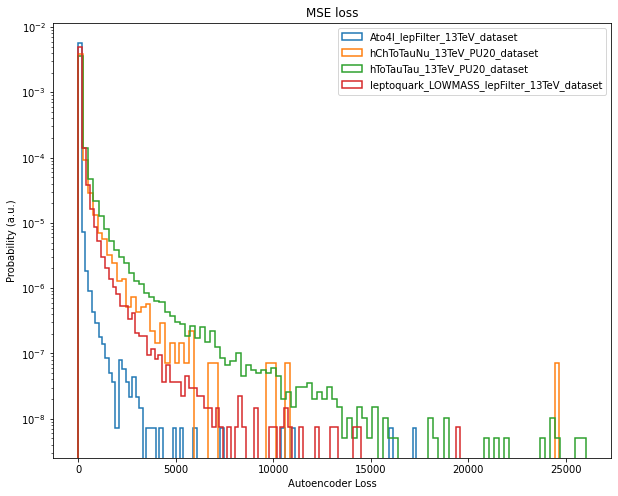

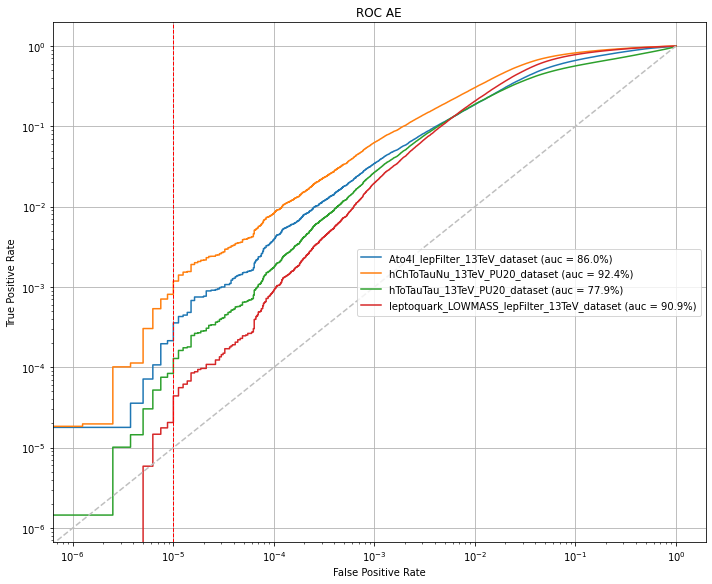

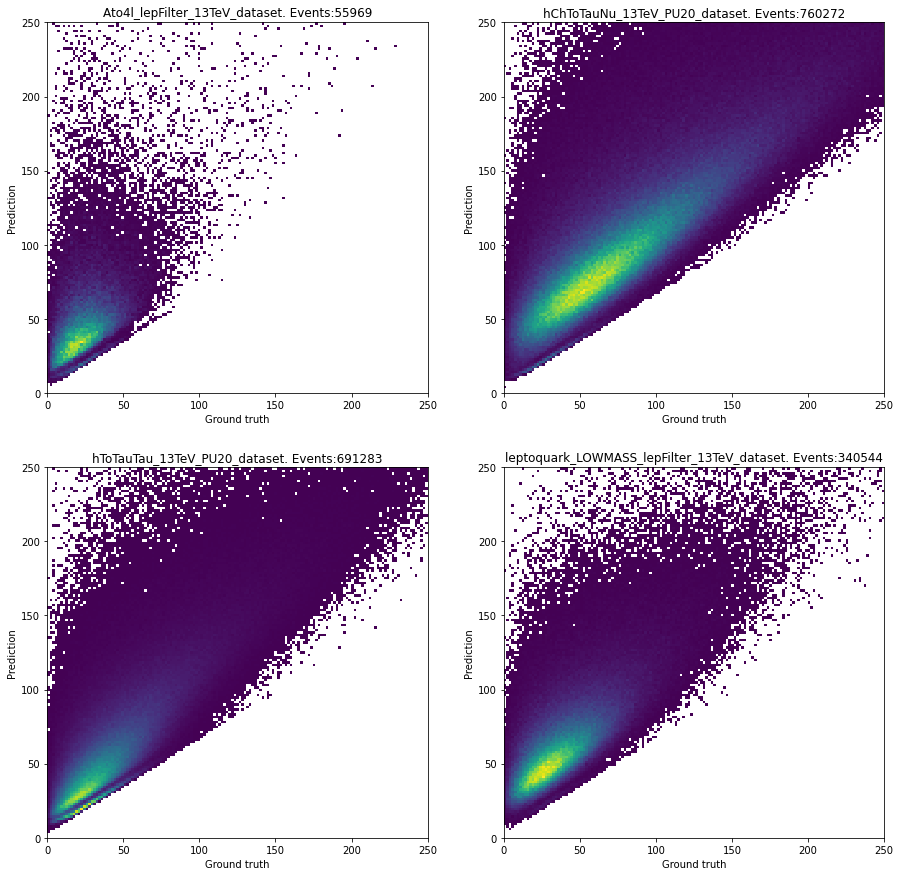

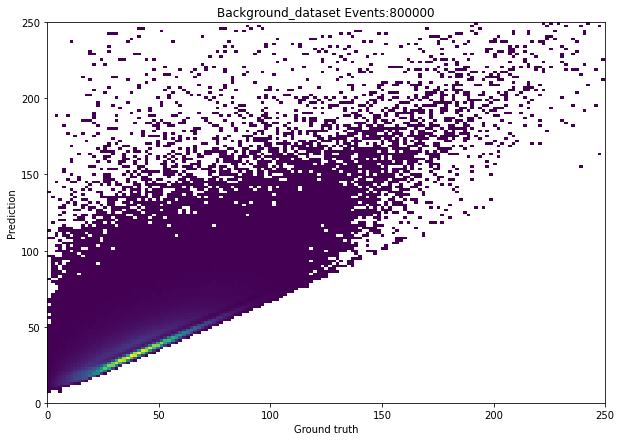

In [54]:
autoencoder("n",None,"y","./plots_save_test/")

In [52]:
date= datetime.now().strftime("_%d_%m")
plot_name = input("Enter plots name(date is added automatically): ")
plot_name = plot_name+date

Enter plots name(date is added automatically): as


In [47]:
def read_bkg_and_signals(bkg_filename,signal_in):
    #Outputs training,test,validation and signal_data data
    #From assigned source/path
    # add correct path to signal files
    signals_file = [signal_in+'Ato4l_lepFilter_13TeV_input_OH_dataset.h5',
                signal_in+'hChToTauNu_13TeV_PU20_input_OH_dataset.h5',
                signal_in+'hToTauTau_13TeV_PU20_input_OH_dataset.h5',
                signal_in+'leptoquark_LOWMASS_lepFilter_13TeV_input_OH_dataset.h5'] 
    # add correct signal labels
    signal_labels = ['Ato4l_lepFilter_13TeV_dataset',
                     'hChToTauNu_13TeV_PU20_dataset',
                     'hToTauTau_13TeV_PU20_dataset',
                     'leptoquark_LOWMASS_lepFilter_13TeV_dataset']    
    with h5py.File(bkg_filename, 'r') as file:
        X_train = np.array(file['X_train'])
        X_test = np.array(file['X_test'])
        X_val = np.array(file['X_val'])
    signal_data = []
    for i, label in enumerate(signal_labels):
        with h5py.File(signals_file[i], 'r') as file:
            test_data = np.array(file['Data'])
        signal_data.append(test_data)
    
    return X_train,X_test,X_val,signal_data,signal_labels



In [46]:
def AE_setup_training(EPOCHS,BATCH_SIZE,X_train,X_test,X_val,signal_data,signal_labels):
    #Autoencoder(AE) model setup
    input_shape = 152
    latent_dimension = 3
    num_nodes=[16,8]
    
    #encoder
    inputArray = Input(shape=(input_shape))
    x = Dense(num_nodes[0], use_bias=False)(inputArray)
    x = Activation('relu')(x)
    x = Dense(latent_dimension, use_bias=False)(x)
    encoder = Activation('relu')(x)
    
    #decoder
    x = Dense(num_nodes[0], use_bias=False)(encoder)
    x = Activation('relu')(x)
    
    decoder = Dense(input_shape)(x)
    #Create AE
    autoencoder = Model(inputs = inputArray, outputs=decoder)
    autoencoder.summary()
    
    #Compile AE
    autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')
    autoencoder.save('flops_test2.h5')#see on get_flopsi jaoks

   
    
    #Treenimine
    #EPOCHS = 10
    #BATCH_SIZE = 1024
    history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))
    
    return autoencoder

In [9]:
def get_flops(path_for_flops):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(path_for_flops)
            
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # Optional: save printed results to file
            # flops_log_path = os.path.join(tempfile.gettempdir(), 'tf_flops_log.txt')
            # opts['output'] = 'file:outfile={}'.format(flops_log_path)

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

    tf.compat.v1.reset_default_graph()

    return flops.total_float_ops


#print('TF Profile: Total number of FLOPs =  {}'.format(get_flops()))
# Profile:
# node name | # float_ops
# Mul                      2.02k float_ops (100.00%, 49.95%)
# Add                      2.02k float_ops (50.05%, 49.93%)
# Sub                          5 float_ops (0.12%, 0.12%)

In [45]:
def predict_signal_bkg(X_test,signal_data,autoencoder):
    #Siia vist vaja panna inference aja võtmine ka
    AE_OH_results=[]
    for i in range(4):
        #All 4 signals predicted
        signal_prediction = autoencoder.predict(signal_data[i])
        AE_OH_results.append(np.array(signal_prediction))
    #Background prediction
    bkg_prediction = autoencoder.predict(X_test)
    AE_OH_results.append(np.array(bkg_prediction))

    
    return AE_OH_results

In [44]:
from keras.models import model_from_json
def load_model(model_name, custom_objects=None):
    name = model_name + '.json'
    json_file = open(name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json, custom_objects=custom_objects)
    model.load_weights(model_name + '.h5')
    return model

def save_model(model_save_name, model):
    with open(model_save_name + '.json', 'w') as json_file:
        json_file.write(model.to_json())
    model.save_weights(model_save_name + '.h5')

In [43]:
def OH_reverse_convert(AE_OH_results):
    resh_type_results=[]
    for i in range(5):
        data=AE_OH_results[i]#take list  with bkg and signals  flattened output
        data=np.reshape(data,(len(data), 19,8))#reshape events by 19 objects
        id_oh=data[:,:,-5:]#take OH vector ids
        id_idmax=np.argmax(id_oh, axis=-1)#find the type
        id_idmax=np.reshape(id_idmax,(len(data),19,1))#reshape for concat
        event_wo_type=data[:,:,:3]#take events wo. type
        reshaped_data=np.concatenate([event_wo_type,id_idmax],axis=-1)#concat.
        resh_type_results.append(reshaped_data)#add to list
    return resh_type_results

In [53]:
def plotting(X_test,AE_OH_results,signal_data,signal_labels,s_plots_path,plot_name):
    
    
    #MSE loss plotting
    #compute loss value (true, predicted)##1 väljund ja plot roc nr 3.
    total_loss = []
    total_loss.append(mse_loss(X_test, AE_OH_results[4].astype(np.float32)).numpy())
    for i, signal_X in enumerate(signal_data):
        total_loss.append(mse_loss(signal_X, AE_OH_results[i].astype(np.float32)).numpy())#
            
    bin_size=100
    
    plt.figure(figsize=(10,8))
    for i, label in enumerate(signal_labels):
        plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log')
    plt.xlabel("Autoencoder Loss")
    plt.ylabel("Probability (a.u.)")
    plt.title('MSE loss')
    plt.legend(loc='best')
    #plt.show()
    plt.savefig(s_plots_path+plot_name+"_MSE.png")
        
    #Roc Curve plotting
    labels = np.concatenate([['Background'], np.array(signal_labels)])
    target_background = np.zeros(total_loss[0].shape[0])
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        if i == 0: continue # background events
        trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
        predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
        auc_loss = auc(fpr_loss, tpr_loss)
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
        plt.semilogx()
        plt.semilogy()
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.legend(loc='center right')
        plt.grid(True)
        plt.tight_layout()
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
    plt.title("ROC AE")
    #plt.show()
    plt.savefig(s_plots_path+plot_name+"_ROC.png")
    
    #2d histogramm plotting
    
    bins=np.linspace(0,250,num=150)
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
    #signal plotting
    for ax,i in zip(axes.flat[0:],[0,1,2,3]):
        ax.set_title(signal_labels[i]+'. Events:{0}'.format(len(signal_data[i])))
        ax.hist2d(signal_data[i][:,0],AE_OH_results[i][:,0],bins=bins,label=label,cmin=1)
        ax.set_ylabel('Prediction')
        ax.set_xlabel('Ground truth')
    plt.savefig(s_plots_path+plot_name+"_signal.png")
    #background plotting
    fig, ax = plt.subplots(figsize =(10, 7))
    matplotlib.pyplot.hist2d(X_test[:,0],AE_OH_results[4][:,0],bins=bins,cmin=1)
    ax.set_title('Background_dataset'+' Events:{0}'.format(len(X_test)))
    ax.set_ylabel('Prediction')
    ax.set_xlabel('Ground truth')
    #plt.show()
    plt.savefig(s_plots_path+plot_name+"_bkg.png")


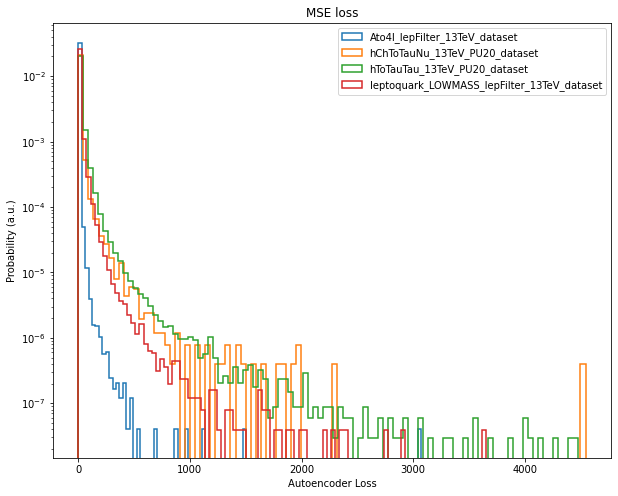

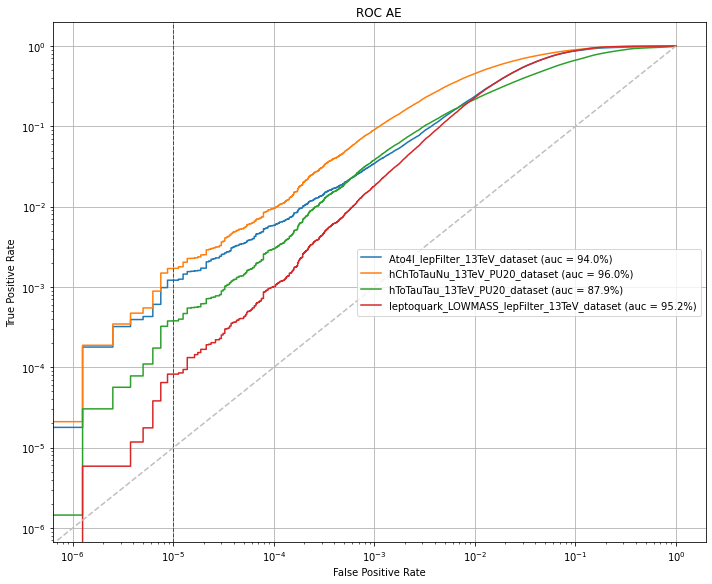

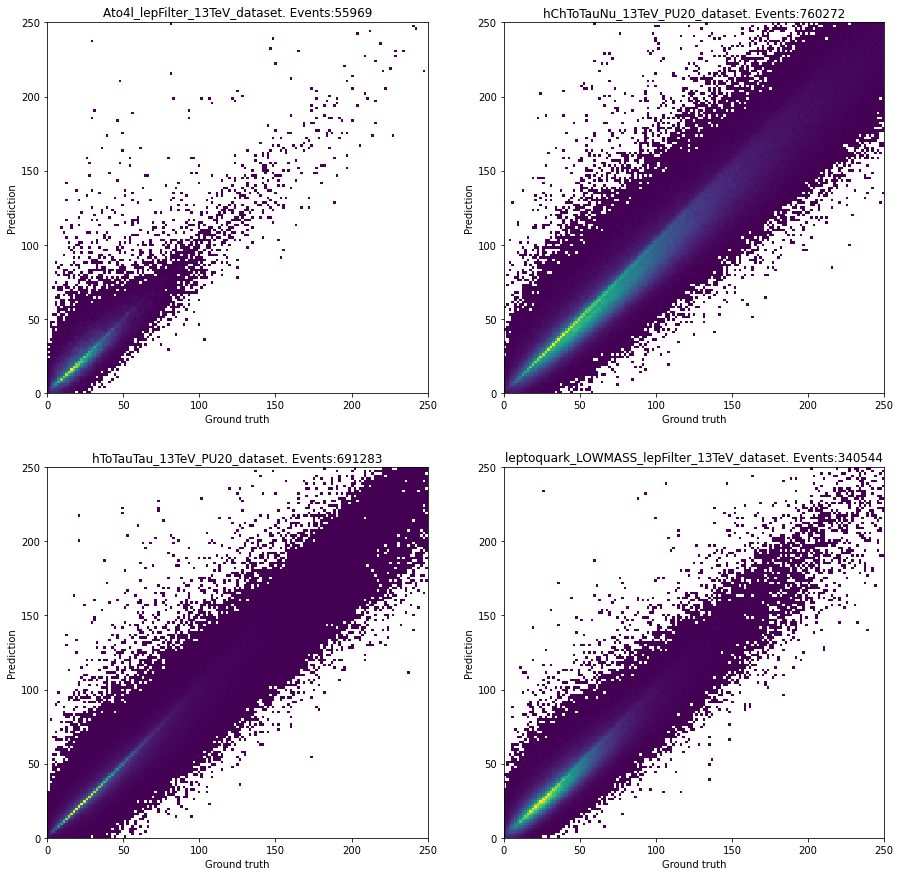

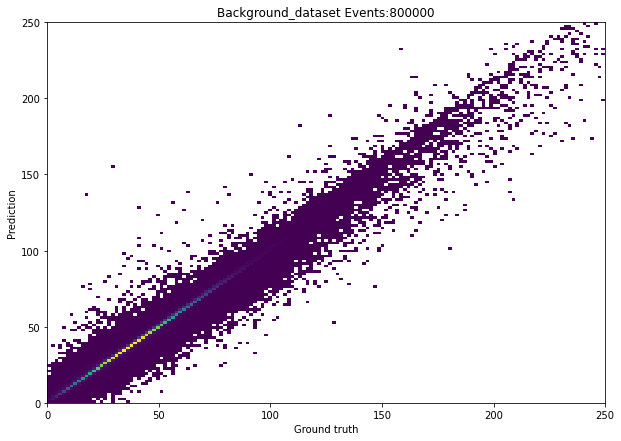

In [20]:
plotting()